In [1]:
import datetime as dt
from finta import TA

import pandas as pd
from pandas_datareader import data as web
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from numpy import size
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

import tensorflow as tf

import keras
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers
from keras.callbacks import History 

np.warnings.filterwarnings('ignore')

In [2]:
def get_stock_data(symbol, start_date, end_date):
    '''
    download stock data over from yahoo api form start date to end date
    input
        stock - String representing stock symbol eg APPL
        start - datetime object represent start date; default Jan 1, 2010
        end - datetime object represent end date; default: Jan 1, 2020
    output
        historical stock data pulled from yahoo finance stock api from start to end dates
    '''
    stockData = web.DataReader(symbol, 'yahoo', start_date, end_date)
    
    return stockData

start_date = dt.datetime(2004, 10, 1)
end_date = dt.datetime(2022, 10, 1)
df_GOOG = get_stock_data('GOOG',start_date, end_date)
df_GOOG.tail(4)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-09-27,100.459999,97.339996,99.910004,98.089996,24225000.0,98.089996
2022-09-28,101.400002,97.800003,98.019997,100.739998,24617000.0,100.739998
2022-09-29,99.300003,96.519997,99.300003,98.089996,21921500.0,98.089996
2022-09-30,99.494003,96.029999,97.730003,96.150002,26248200.0,96.150002


In [3]:
df_GOOG.rename(columns = {'High':'high', 'Low': 'low', 'Open':'open','Close':'close','Volume':'volume', 'Adj Close':'adj_close'}, inplace = True)

In [4]:
rsi = TA.RSI(df_GOOG)
obv = TA.OBV(df_GOOG)
bbands = TA.BBANDS(df_GOOG, 21)

df_GOOG['OBV'] = obv.values
df_GOOG = pd.concat([df_GOOG, rsi], axis = 1)
df_GOOG = pd.concat([df_GOOG, bbands], axis = 1)
df_GOOG = df_GOOG.dropna()
df_GOOG.describe()

,high,low,open,close,volume,adj_close,OBV,14 period RSI,BB_UPPER,BB_MIDDLE,BB_LOWER
count,4511.000000,4511.000000,4511.000000,4511.000000,4.511000e+03,4511.000000,4.511000e+03,4511.000000,4511.000000,4511.000000,4511.000000
mean,37.576318,36.823572,37.200643,37.205834,1.227037e+08,37.205834,2.016020e+10,54.217064,39.072900,36.990104,34.907309
std,35.182853,34.445349,34.809058,34.815612,1.505469e+08,34.815612,3.846793e+09,12.633815,36.664160,34.684090,32.755789
min,4.221676,4.017691,4.096396,4.112087,1.584340e+05,4.112087,-8.102176e+08,21.330543,4.602334,3.816469,2.743964
25%,12.826547,12.538752,12.695290,12.676859,3.014000e+07,12.676859,1.919959e+10,44.767545,13.464443,12.686246,11.697362
50%,23.112617,22.821959,23.021212,22.988832,6.859214e+07,22.988832,2.112246e+10,53.936424,23.350873,22.487651,21.638335
75%,53.558750,52.362125,52.915998,53.011000,1.530796e+08,53.011000,2.180190e+10,63.436345,55.625090,52.866928,50.030339
max,152.100006,149.887497,151.863495,150.709000,1.650833e+09,150.709000,2.668921e+10,90.929456,154.074570,147.882762,144.401245


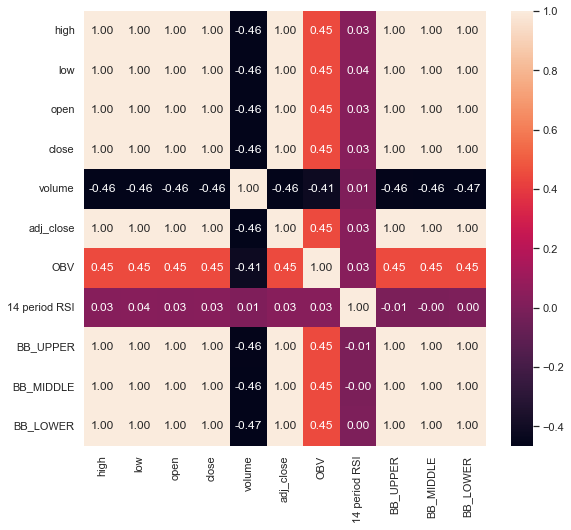

In [6]:
sns.set (rc = {'figure.figsize':(9, 8)})
sns.heatmap(df_GOOG.corr(), annot=True,fmt='.2f');

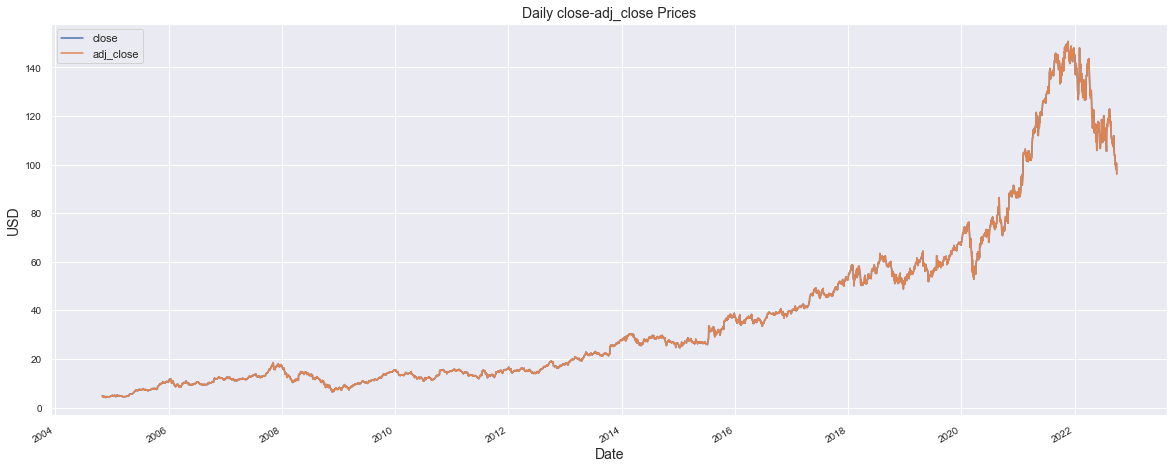

In [9]:
def plot_df(df, col, title=None):
    '''
    plot stock information
    input: 
        df - pandas dataframe containing historical stock information 
        col - array of strings: column names in df to plot
        title - title of plot.
    output: None
    '''
    fontsize=10
    if title == None:
        title = 'Daily '
        for c_name in col:
            title += c_name+'-'
        title = title[:-1]+' Prices'
        
    df[col].plot(figsize=(20,8), fontsize=fontsize);
    plt.title(title, fontsize=fontsize+4)
    plt.ylabel("USD", fontsize=fontsize+4)
    plt.xlabel("Date", fontsize=fontsize+4)
    plt.show()

plot_df(df_GOOG, ['close','adj_close'], )

In [11]:
X = df_GOOG.drop(['adj_close'], axis=1)
y = df_GOOG['adj_close']

In [15]:
#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, test_size=.3, random_state=42)

In [ ]:
normaliser = preprocessing.MinMaxScaler()
train_normalised_data = normaliser.fit_transform(train_data)
test_normalised_data = normaliser.transform(test_data)

In [19]:
# model architecture

lstm_input = Input(shape=(50, 5), name='lstm_input')
x = LSTM(50, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
x = Dense(64, name='dense_0')(x)
x = Activation('sigmoid', name='sigmoid_0')(x)
x = Dense(1, name='dense_1')(x)
output = Activation('linear', name='linear_output')(x)

model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam(lr=0.0005)
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=32, epochs=50, shuffle=True, validation_split=0.1)


Epoch 1/50


ValueError: in user code:

    File "c:\Programs\Python\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Programs\Python\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Programs\Python\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Programs\Python\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Programs\Python\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Programs\Python\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_1" is incompatible with the layer: expected shape=(None, 50, 5), found shape=(None, 10)


In [23]:
X_train.shape

(3157, 10)